In [1]:
import torch
import copy
from torchvision import models
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
 
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
green_dir1 = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\green1'
green_dir2 = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\green2'
yellow_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\yellow'
red_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\red'
blue_dir = f'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CAE_dataset\\blue'

green_set1 = datasets.ImageFolder(
    green_dir1,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

green_set2 = datasets.ImageFolder(
    green_dir2,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

yellow_set = datasets.ImageFolder(
    yellow_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

red_set = datasets.ImageFolder(
    red_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

blue_set = datasets.ImageFolder(
    blue_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

train_set1, test_set1 = torch.utils.data.random_split(green_set1, [250, 50])
train_set2, test_set2 = torch.utils.data.random_split(green_set2, [250, 50])
test_set = test_set1 + test_set2

normal_set = green_set1 + green_set2
abnormal_set = red_set + yellow_set + blue_set

In [3]:
def make_dir(args):    
    import os

    MODEL_DIR = f"FL_model/client = {args.num_clients}"
    try:
        os.makedirs(MODEL_DIR)
    except FileExistsError:
        print('Directories not created because they already exist')

In [4]:
def list_np_tensor(param_data):
    data = []
    for i in range(np.size(param_data, 0)):
        data.append(np.concatenate((param_data[i]['net.0.weight'].cpu().numpy(), np.expand_dims(param_data[i]['net.0.bias'].cpu().numpy(), axis=1)),axis=1))
    
    data = torch.Tensor(data)
    return data
    
def save_param(param_data):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    dtf = pd.DataFrame(dt)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def save_param_with_round(param_data, round_list, args):
    dt = list_np_tensor(param_data)
    dt = dt.view(args.num_clients*args.num_rounds, -1)
    
    round_tensor = torch.tensor(round_list).view(-1, 1)
    dt_r = torch.cat((dt, round_tensor), dim=1)
    
    dtf = pd.DataFrame(dt_r)
    dtf.to_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    print('finished save')

def load_data(args):    
    ldt = pd.read_csv(f"Final/parameter_data/param_data_{args.num_clients}.csv")
    ldt = ldt.values
    ldt = np.delete(ldt, 0, 1)
    return ldt

def data_split(args):
    dataset_list=[]

    num_data_arr = np.ones((args.num_clients,), dtype=int) * int(len(train_dataset)/args.num_clients)
    dataset_list = torch.utils.data.random_split(train_dataset, num_data_arr)
    return dataset_list

In [5]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
        
        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
            nn.ReLU())

        self.tran_cnn_layer2 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size = 2, stride = 2, padding=0),
            nn.Sigmoid())
            
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)      
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        
        return output

In [6]:
def define_client(partition, r, num, args):
    train_loader = DataLoader(partition[f'train{num+1}'], batch_size=args.batch_size, shuffle=True)
    
    if r == 0:
        net = ConvAutoEncoder().to(device)
    else:
        net = torch.load(args.INIT_PATH)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)

    return net, train_loader, criterion, optimizer

In [7]:
def train(net, train_loader, criterion, optimizer, args):
    
    train_loss = 0
    for epoch in range(args.num_epochs):        
        for images, _ in train_loader:
            images = images.to(device)
            
            optimizer.zero_grad() 
            
            outputs = net(images)  
            loss = criterion(outputs, images)

            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
    train_loss /= len(train_loader)*args.num_epochs

    torch.save(net, args.NET_PATH)
    return net, train_loss

In [8]:
def Fed_AVG(model, client_model_list, args):
    model.train()
    local_weights = []

    for i in range(args.num_clients):
        local_weights.append(copy.deepcopy(client_model_list[i].state_dict()))
    w_avg = copy.deepcopy(local_weights[0]) #type of w_avg : <class 'collections.OrderedDict'>

    for key in w_avg.keys():
        for i in range(1,len(local_weights)):
            w_avg[key] += local_weights[i][key]
        w_avg[key] = torch.div(w_avg[key], len(local_weights))

    global_weights = w_avg
    model.load_state_dict(global_weights)
    torch.save(model, args.INIT_PATH)

    return model, local_weights

In [9]:
def test(model, partition, criterion, args):
    test_loader = DataLoader(partition[f'test'], batch_size=args.batch_size, shuffle=True)
    model.eval()

    loss = 0
    round_loss = 0
            
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)
        loss += criterion(outputs, images).item()
    
    round_loss = loss / len(test_loader)
 
    return round_loss

In [10]:
def score(model, normalset, criterion, t):    
    normal_loader = DataLoader(normalset, batch_size=args.batch_size, shuffle=True)
    abnormal_loader = DataLoader(abnormal_set, batch_size=args.batch_size, shuffle=True)

    normal_err = 0
    abnormal_err = 0    
    
    for i, (X_normal, _) in enumerate(normal_loader):
        X_normal = X_normal.cuda()
        output = model(X_normal)
        loss = criterion(X_normal, output)
        
        if loss.item() > t:
            normal_err += 1
        
    for i, (X_abnormal, _) in enumerate(abnormal_loader):
        X_abnormal = X_abnormal.cuda()
        output = model(X_abnormal)
        loss = criterion(X_abnormal, output)
        
        if loss.item() < t:
            abnormal_err += 1
      
    #err = ((normal_err/len(normal_loader)) + (abnormal_err/len(abnormal_loader)))/2.0
    err = (normal_err + abnormal_err) / (len(normal_loader) + len(abnormal_loader))
    acc = 1 - err
    
    return acc

In [11]:
def experiment(partition, args):
    model = ConvAutoEncoder().to(device)
    torch.save(model, args.INIT_PATH)

    round_losses = []
    param_data = []
    round_list = []
    acc_list = []

    for r in range(args.num_rounds):
        client_model_list = []
        
        for num in range(args.num_clients):
            setattr(args, 'NET_PATH', f'FL_model/client = {args.num_clients}/client_{num}.pth')
            
            net, train_loader, criterion, optimizer = define_client(partition, r, num, args)
            net, train_loss = train(net, train_loader, criterion, optimizer, args)
            
            client_model_list.append(net)

        model, local_weights = Fed_AVG(model, client_model_list, args)
        round_loss = test(model, partition, criterion, args)

        if args.score == True:
            acc = score(model, partition['normal_set'], criterion, args.threshold[0])
            acc_list.append(acc)

        if r%50==0 or r==args.num_rounds-1:
            if args.score==True:
                print(f'[Round {r}] Round Loss: {round_loss:.5f} Round Acc: {acc:.3f}')
            else:
                print(f'[Round {r}] Round Loss: {round_loss:.5f}')

        round_losses.append(round_loss)
        round_list.append([r, r, r])
        param_data += local_weights

        if args.save==True and r+1 in args.save_per_round:
            torch.save(model, f'model_per_round/round_{r+1}_weight.pth')
        
    return round_losses, round_list, acc_list, param_data

In [12]:
def train_separately(partition, args):

    def test(model, test_loader, criterion, args):
        model.eval()

        loss = 0
        round_loss = 0
                
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            loss += criterion(outputs, images).item()
        
        round_loss = loss / len(test_loader)

        return round_loss


    train_loader1 = DataLoader(partition['train1'], batch_size=args.batch_size, shuffle=True)
    train_loader2 = DataLoader(partition['train2'], batch_size=args.batch_size, shuffle=True)
    test_loader1 = DataLoader(partition['test1'], batch_size=args.batch_size, shuffle=True)
    test_loader2 = DataLoader(partition['test2'], batch_size=args.batch_size, shuffle=True)

    model1 = ConvAutoEncoder().to(device)
    model2 = ConvAutoEncoder().to(device)
    
    criterion = nn.MSELoss()
    optimizer1 = optim.Adam(model1.parameters(), lr=args.lr)
    optimizer2 = optim.Adam(model2.parameters(), lr=args.lr)

    test_losses1, test_losses2 = [], []
    acc1_list, acc2_list = [], []


    for epoch in range(args.num_rounds):        

        train_loss1, train_loss2, test_loss1, test_loss2 = 0, 0, 0, 0

        for images, _ in train_loader1:
            images = images.to(device)
            
            optimizer1.zero_grad() 
            
            outputs = model1(images)  
            loss = criterion(outputs, images)

            loss.backward()
            optimizer1.step()

            train_loss1 += loss.item()
        train_loss1 /= len(train_loader1)

        test_loss1 = test(model1, test_loader1, criterion, args)
        test_losses1.append(test_loss1)

        if args.score == True:
            acc1 = score(model1, partition['normal_set'], criterion, args.threshold[1])
            acc1_list.append(acc1)

        for images, _ in train_loader2:
            images = images.to(device)
            
            optimizer2.zero_grad() 
            
            outputs = model2(images)  
            loss = criterion(outputs, images)

            loss.backward()
            optimizer2.step()

            train_loss2 += loss.item()
        train_loss2 /= len(train_loader2)

        test_loss2 = test(model2, test_loader2, criterion, args)
        test_losses2.append(test_loss2)

        if args.score == True:
            acc2 = score(model2, partition['normal_set'], criterion, args.threshold[2])
            acc2_list.append(acc2)


        if epoch%50 == 0 or epoch==args.num_rounds-1:
            if args.score == True:
                print(f"[{epoch}/{args.num_rounds}] Loss1: {train_loss1:.5f}/{test_loss1:.5f} Loss2: {train_loss2:.5f}/{test_loss2:.5f} Acc: {acc1:.3f}/{acc2:.3f}")
            else:
                print(f"[{epoch}/{args.num_rounds}] Loss1: {train_loss1:.5f}/{test_loss1:.5f} Loss2: {train_loss2:.5f}/{test_loss2:.5f}")

    torch.save(model1, f"each_model/model1.pth")
    torch.save(model2, f"each_model/model2.pth")

    return test_losses1, test_losses2, acc1_list, acc2_list

In [13]:
def plot_graph(x, x_list, ylabel='Loss'):
    plt.plot(x, label='FedAvg')
    if len(x_list) != 1:
        plt.plot(x_list[0], label='Client1')
        plt.plot(x_list[1], label='Client2')
    else:
        plt.plot(x_list, label='Clients')
        
    plt.xlabel('Round')
    plt.ylabel('Loss') if ylabel=='Loss' else plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()


def plot_loss_zoom(round_loss, round_client_losses=None, xlim=(-0.05, 1), ylim=(0.0,0.01)):
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes
    ax = plt.subplot(1,1,1)
    ax.plot(round_loss, label='Avg')
    if round_client_losses != None:
        ax.plot(np.array(round_client_losses)[0], label='Client1')
        ax.plot(np.array(round_client_losses)[1], label='Client2')
    ax.grid()
    ax.legend()

    axins = inset_axes(ax, 1.0, 0.8, loc = 1, bbox_to_anchor=(0.6, 0.75), bbox_transform = ax.figure.transFigure)
    
    axins.plot(round_loss, label = 'Avg')
    if round_client_losses != None:
        axins.plot(np.array(round_client_losses)[0], label = 'Client1')
        axins.plot(np.array(round_client_losses)[1], label = 'Client2')
    axins.set_xlim(xlim)
    axins.set_ylim(ylim)
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec = "0.4")

    plt.show()

In [14]:
def save_loss(loss, client_losses=None):
    dtf_loss = pd.DataFrame(loss)
    dtf_loss.to_csv(f"Loss/loss.csv")

    if client_losses != None:
        dtf_client_losses = pd.DataFrame(client_losses)
        dtf_client_losses.to_csv(f"Loss/client_losses.csv")
        
    print('save loss & acc')

def save_acc(acc, client_acces=None):
    dtf_acc = pd.DataFrame(acc)
    dtf_acc.to_csv(f"Acc/acc.csv")

    if client_acces != None:
        dtf_client_acces = pd.DataFrame(client_acces)
        dtf_client_acces.to_csv(f"Acc/client_acces.csv")
        
    print('save loss & acc')


def load_data(): 
    ldt_loss = pd.read_csv(f"Loss/loss.csv")
    ldt_client_losses = pd.read_csv(f"Loss/client_losses.csv")
    ldt_acc = pd.read_csv(f"Acc/acc.csv")
    ldt_client_acces = pd.read_csv(f"Acc/client_acces.csv")

    ldt_loss, ldt_client_losses = np.delete(ldt_loss.values, 0, 1), np.delete(ldt_client_losses.values, 0, 1)
    ldt_client_loss1, ldt_client_loss2 = ldt_client_losses[0,:], ldt_client_losses[1,:]

    ldt_acc, ldt_client_acces = np.delete(ldt_acc.values, 0, 1), np.delete(ldt_client_acces.values, 0, 1)
    ldt_client_acc1, ldt_client_acc2 = ldt_client_acces[0,:], ldt_client_acces[1,:]

    return ldt_loss, ldt_client_loss1, ldt_client_loss2, ldt_acc, ldt_client_acc1, ldt_client_acc2

#### **Ex 1) Just Train**

In [14]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.num_epochs = 5
args.num_rounds = 300
args.num_clients = 2
args.lr = 0.0001

args.batch_size = 8

args.save = True
args.save_per_round = [5, 300, 500]

args.score = False
args.threshold = None 

#####################################
make_dir(args)

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'


partition = {'train1':train_set1, 'train2':train_set2, 'test':test_set, 'test1':test_set1, 'test2':test_set2, 'normal_set':normal_set}

round_loss, round_list, _, param_data = experiment(partition, args)
test_losses1, test_losses2, _, _ = train_separately(partition, args)

Directories not created because they already exist
[Round 0] Round Loss: 0.04927 
[Round 10] Round Loss: 0.00220 
[Round 20] Round Loss: 0.00136 
[Round 30] Round Loss: 0.00102 
[Round 40] Round Loss: 0.00093 
[Round 50] Round Loss: 0.00088 
[Round 60] Round Loss: 0.00083 
[Round 70] Round Loss: 0.00081 
[Round 80] Round Loss: 0.00075 
[Round 90] Round Loss: 0.00075 
[Round 100] Round Loss: 0.00070 
[Round 110] Round Loss: 0.00068 
[Round 120] Round Loss: 0.00067 
[Round 130] Round Loss: 0.00065 
[Round 140] Round Loss: 0.00065 
[Round 150] Round Loss: 0.00066 
[Round 160] Round Loss: 0.00063 
[Round 170] Round Loss: 0.00061 
[Round 180] Round Loss: 0.00063 
[Round 190] Round Loss: 0.00061 
[Round 200] Round Loss: 0.00060 
[Round 210] Round Loss: 0.00060 
[Round 220] Round Loss: 0.00058 
[Round 230] Round Loss: 0.00059 
[Round 240] Round Loss: 0.00058 
[Round 250] Round Loss: 0.00060 
[Round 260] Round Loss: 0.00058 
[Round 270] Round Loss: 0.00056 
[Round 280] Round Loss: 0.00056 
[Ro

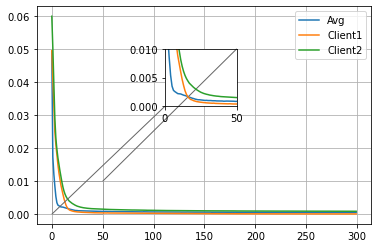

save loss & acc


In [25]:
plot_loss(round_loss, [test_losses1, test_losses2])
save_loss(round_loss, [test_losses1, test_losses2])

#### **Ex 2) Train with Acc**

In [15]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")

args.num_epochs = 5
args.num_rounds = 300
args.num_clients = 2
args.lr = 0.00007

args.batch_size = 8

args.save = True
args.save_per_round = [5, 100, 200, 250, 300]

args.score = True
args.threshold = [0.0007761013705347276, 0.00207, 0.00119]

#####################################
make_dir(args)

args.NET_PATH = ''
args.INIT_PATH = f'FL_model/client = {args.num_clients}/initialize_weight.pth'


partition = {'train1':train_set1, 'train2':train_set2, 'test':test_set, 'test1':test_set1, 'test2':test_set2, 'normal_set':normal_set}

round_loss, round_list, fed_acc_list, param_data = experiment(partition, args)
test_losses1, test_losses2, client1_acc_list, client2_acc_list = train_separately(partition, args) 

Directories not created because they already exist
[Round 0] Round Loss: 0.05310 Round Acc: 0.750
[Round 50] Round Loss: 0.00084 Round Acc: 0.830
[Round 100] Round Loss: 0.00070 Round Acc: 0.893
[Round 150] Round Loss: 0.00059 Round Acc: 0.970
[Round 200] Round Loss: 0.00057 Round Acc: 0.970
[Round 250] Round Loss: 0.00055 Round Acc: 0.977
[Round 299] Round Loss: 0.00054 Round Acc: 0.977
[0/300] Loss1: 0.05395/0.05015 Loss2: 0.05642/0.05457 Acc: 0.750/0.750
[50/300] Loss1: 0.00061/0.00066 Loss2: 0.00190/0.00189 Acc: 0.800/0.830
[100/300] Loss1: 0.00038/0.00042 Loss2: 0.00134/0.00134 Acc: 0.877/0.990
[150/300] Loss1: 0.00028/0.00031 Loss2: 0.00113/0.00113 Acc: 0.920/1.000
[200/300] Loss1: 0.00022/0.00023 Loss2: 0.00103/0.00102 Acc: 0.960/1.000
[250/300] Loss1: 0.00018/0.00019 Loss2: 0.00097/0.00097 Acc: 0.957/1.000
[299/300] Loss1: 0.00015/0.00016 Loss2: 0.00093/0.00093 Acc: 1.000/1.000


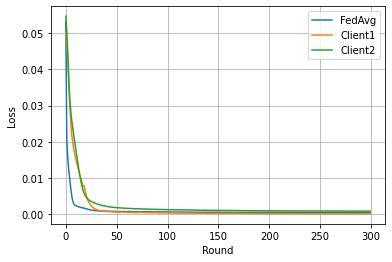

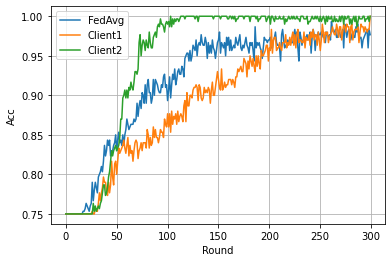

save loss & acc
save loss & acc


In [17]:
plot_graph(round_loss, [test_losses1, test_losses2])
plot_graph(fed_acc_list, [client1_acc_list, client2_acc_list], ylabel='Acc')
save_loss(round_loss, [test_losses1, test_losses2])
save_acc(fed_acc_list, [client1_acc_list, client2_acc_list])